# Lending Club Data Analysis - Lab 2

Brady Arendale, Aaron Cattley, John Partee

# Data Preparation Part 1

The original data is 131,141 rows of 150 columns, which we reduced to these 18 chosen attributes by intuition. We also opted to only consider individual loan applicants, which allowed us to further reduce the dimensions of the data. This downselection left us with 18 columns (17 explanatory variables), and 111,863 rows. 

We've gone through the variables needed for this analysis and done the following:
   - Converted certain variables to empirical and numerical lengths
   - Imputed necessary values that were NA using inferred values
   - Rolled up Sub-grade group as the variable had too many levels (25)
   - Created dummy variables for the class variables to for proper classification

Previously we utilized dimensionality reduction, but due to the heavily weighted nature of the data we did not find this method useful.  Within the response variable loan_status, the levels of 'Late' and 'Unpaid' were removed as we focused solely on whether a person defaults or pays in full.

In [1]:
#setup block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read in the data
df = pd.read_csv('LoanStats_securev1_2019Q2.csv')

#narrow it down to single applications, not joint, and drop application type
df = df.loc[df['application_type'] == 'Individual']
df = df.drop(columns = ['application_type'])

#make the emp_length numerical
df['emp_length'] = df['emp_length'].fillna('0').str.extract('(\d+)').astype(int)

#Make int_rate numerical
df['int_rate'] = df['int_rate'].str.extract('(\d+)').astype(float)

#Make inq_last_6mths an integer
df['inq_last_6mths'] = df['inq_last_6mths'].astype(int)

#Make open_acc an integer
df['open_acc'] = df['open_acc'].astype(int)

#Make pub_rec an integer
df['pub_rec'] = df['pub_rec'].astype(int)

#Some light feature engineering for earliest_cr_line, which is not a factor, but a descrete variable. 
from datetime import datetime
def timeFromJun19(date):
  date = datetime.strptime(date, '%b-%Y')
  return (2019 - date.year)*12 + 6 - date.month

df['earliest_cr_line'] = df['earliest_cr_line'].apply(timeFromJun19)

#Lastly, we're going to consolidate the 'good' and 'bad' loan labels into two groups- We want to get paid,
#so the degree of lateness is irrelevant! 
df = df.replace(['Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period'],
                "Late or Unpaid")
df = df.replace(['Current', 'Fully Paid'],
                'Current or Fully Paid')

#Roll up sub grade to simplify dummy variables
df['letter_grade'] = [i[0] for i in df['sub_grade']]

#Remove sub grade
del df['sub_grade']

In [3]:
df.info()
print("\nDuplicated records: ")
df.duplicated().value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111863 entries, 0 to 131138
Data columns (total 19 columns):
Unnamed: 0             111863 non-null int64
loan_amnt              111863 non-null float64
term                   111863 non-null object
int_rate               111863 non-null float64
purpose                111863 non-null object
emp_length             111863 non-null int64
home_ownership         111863 non-null object
annual_inc             111863 non-null float64
verification_status    111863 non-null object
addr_state             111863 non-null object
dti                    111863 non-null float64
earliest_cr_line       111863 non-null int64
fico_range_low         111863 non-null float64
inq_last_6mths         111863 non-null int64
open_acc               111863 non-null int64
pub_rec                111863 non-null int64
revol_bal              111863 non-null float64
loan_status            111863 non-null object
letter_grade           111863 non-null object
dtypes: float64

False    111863
dtype: int64

In [4]:
df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
df_dummy = pd.get_dummies(df, drop_first=True)

X = df_dummy.drop('loan_status_Late or Unpaid', axis=1)
y = df_dummy['loan_status_Late or Unpaid']

# Data Preparation Part 2

The final data set includes 13 continous variables and 6 one-hot encoded categorical variables, for a total of 83 features.  


In [5]:
df_dummy.describe()

,loan_amnt,int_rate,emp_length,annual_inc,dti,earliest_cr_line,fico_range_low,inq_last_6mths,open_acc,pub_rec,...,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,loan_status_Late or Unpaid,letter_grade_B,letter_grade_C,letter_grade_D,letter_grade_E,letter_grade_F
count,111863.000000,111863.000000,111863.000000,1.118630e+05,111863.000000,111863.000000,111863.00000,111863.000000,111863.000000,111863.000000,...,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000
mean,15867.522997,12.235681,5.180319,8.822018e+04,18.701632,194.445223,705.03102,0.432618,12.001448,0.109920,...,0.021571,0.012176,0.005694,0.001824,0.012274,0.284464,0.235663,0.141593,0.000107,0.000036
std,10107.867565,4.843253,3.825286,1.089210e+05,8.712867,94.316113,33.94230,0.724139,6.109479,0.318204,...,0.145279,0.109670,0.075247,0.042666,0.110106,0.451161,0.424415,0.348634,0.010357,0.005980
min,1000.000000,6.000000,0.000000,6.000000e+03,0.000000,37.000000,660.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8075.000000,8.000000,1.000000,5.000000e+04,12.170000,135.000000,680.00000,0.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13000.000000,12.000000,5.000000,7.200000e+04,18.150000,176.000000,700.00000,0.000000,11.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21275.000000,15.000000,10.000000,1.038580e+05,24.810000,239.000000,725.00000,1.000000,15.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,40000.000000,30.000000,10.000000,8.608920e+06,39.990000,821.000000,845.00000,5.000000,93.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Modeling and Evaluation 1

The final data set includes 13 continous variables and 6 categorical variables. Through classification we are attempting to predict if someone will default on a loan to overall manage our profitability. We are particularly focused on minimizing false negatives (loans that default predicted to not default) since these are the cases that can cost us money. Therefore, we will use recall. We are concerned with how useful the results are in this case, more so than how complete. Overall accuracy is less important as there are still a huge number of loans to invest in, with limited capital. Even if we miss out on a few high interest loans that we misclassify, it is better to slightly lower our profit than to lose our whole investment into a loan. 

For regression, we will use mean absolute error. MAE is often used for financial data because, for instance, a \\$10 residual is twice as bad as a \\$5 residual. Equivalently, two \\$5 residuals are just as bad as one \\$10 residual. To put it another way, if we lose \\$10 total, we do not care if it is on one loan or two loans. MSE would penalize the one larger residual harsher than the two smaller residuals, even though they are equivalent for our purposes.

# Modeling and Evaluation 2

We will be using an 80/20 stratified training/test split. We require a stratified split as we have categorical variables that are unevenly weighted.  This is due to the fact that in our dataset, the variables and overall responses are weighted heavily to not defaulting on the loan. If we did not apply this weighted theory, we have a likely chance of our folds in our training set not containing equal representation of both/all groups within a variable. Additionally, when models are trained with fewer negative cases they tend to overclassify the data as all good loans.

We will also use stratified cross-validation (5- or 10-fold depending on the algorithm) to tune our hyperparameters. This will give us a good idea of what hyperparameters will lead to the best results for recall and mean absolute error on test data as well as future data that the model has not seen.

# Modeling and Evaluation 3

## Setup

In [6]:
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Create train/test splits for classification and standardize over each
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9001)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Create regression variables and train/test splits and standardize
X_reg = X.drop(columns='loan_amnt')
y_reg = X['loan_amnt']
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=9001)
scaler = StandardScaler().fit(X_reg_train)
X_reg_train_scaled = scaler.transform(X_reg_train)
X_reg_test_scaled = scaler.transform(X_reg_test)

## Classification: Elastic net logistic regression

Elastic net regression is a hybrid of LASSO and ridge regression. We tested 6 values of C (the regularization parameter) and 5 values of L1 ratio (the mixing parameter of LASSO and ridge) and used cross-validation to find the best combination.

In [7]:
from sklearn.linear_model import LogisticRegressionCV
log_model = LogisticRegressionCV(Cs=[.0001,.001,.01,.1,1,10], scoring='recall', class_weight='balanced', random_state=9001, 
                                 cv=10, penalty='elasticnet', solver='saga', l1_ratios=[0.1,0.3,0.5,0.7,0.9], n_jobs=-1)
log_model = log_model.fit(X_train_scaled, y_train)
log_model.score(X_test_scaled, y_test)

F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached w

F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\brady\Anaconda3\envs\ML7331\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached w

0.5454545454545454

In [92]:
y_hat = log_model.predict(X_test_scaled)
print('C chosen by cross-validation:', log_model.C_)
print('L1 ratio chosen by cross-validation:', log_model.l1_ratio_)
print('Test recall:', mt.recall_score(y_test, y_hat))
print('Test confusion matrix:\n', mt.confusion_matrix(y_test, y_hat))

C chosen by cross-validation: [0.01]
L1 ratio chosen by cross-validation: [0.7]
Test recall: 0.5454545454545454
Test confusion matrix:
 [[15017  7081]
 [  125   150]]


In [93]:
log_probas = log_model.predict_proba(X_test_scaled)
log_y_hat = y_hat

## Classification: Random Forest classifier

For random forest, we tested max tree depths from 2 to 5. A max tree depth of 4 produced the best cross-validated results.

In [29]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for i in range(2,6):
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=i*10, random_state=9001, class_weight='balanced', n_jobs=-1)
    cv_score = cross_val_score(rf_clf, X_train, y_train, scoring='recall', cv=10)
    print('For max depth of {}, cross-validated recall is:\n {}'.format(i, cv_score))
    print('Mean recall is:', np.mean(cv_score))

For max depth of 2, cross-validated recall is:
 [0.55454545 0.5        0.53636364 0.40909091 0.5        0.48181818
 0.50909091 0.56363636 0.37614679 0.47706422]
Mean recall is: 0.4907756463719767
For max depth of 3, cross-validated recall is:
 [0.56363636 0.53636364 0.52727273 0.46363636 0.5        0.5
 0.52727273 0.57272727 0.41284404 0.49541284]
Mean recall is: 0.5099165971643036
For max depth of 4, cross-validated recall is:
 [0.56363636 0.57272727 0.51818182 0.45454545 0.49090909 0.49090909
 0.53636364 0.59090909 0.39449541 0.51376147]
Mean recall is: 0.5126438698915763
For max depth of 5, cross-validated recall is:
 [0.54545455 0.53636364 0.51818182 0.45454545 0.47272727 0.46363636
 0.51818182 0.55454545 0.3853211  0.50458716]
Mean recall is: 0.49535446205170974


In [32]:
#Max depth 4 yielded best results
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=9001, class_weight='balanced', n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_hat = rf_clf.predict(X_test)
print('Feature importances:\n', rf_clf.feature_importances_)

Feature importances:
 [1.77028328e-02 2.96000119e-01 4.89347268e-02 4.43784380e-02
 7.08445698e-02 2.04450004e-02 6.17312837e-02 2.48306642e-02
 1.94661876e-02 1.59528879e-03 4.29540133e-02 5.34305450e-03
 1.72128438e-02 6.42719882e-03 1.11403902e-03 1.53008767e-03
 1.36217914e-03 3.35748018e-03 2.99444079e-03 2.46437495e-03
 8.64752916e-05 2.24179812e-04 1.39349912e-03 9.65793357e-04
 1.13963521e-03 1.14959761e-03 2.70988499e-03 2.11528601e-02
 2.04982075e-03 1.36438007e-04 1.82197362e-03 5.44156592e-03
 4.89829092e-03 1.89076895e-03 0.00000000e+00 5.98656375e-03
 1.42352853e-03 1.06176653e-03 1.06882558e-04 5.07712469e-04
 4.60654463e-03 1.03431217e-03 6.06130341e-04 8.91305960e-05
 3.57232536e-04 3.59225280e-04 6.61724442e-04 8.04601377e-04
 4.60132015e-04 4.24021027e-03 1.36396629e-03 1.06813921e-03
 4.65897118e-04 1.78030985e-03 1.07846249e-04 3.45561874e-04
 6.93404306e-04 2.20522828e-03 2.97559246e-04 5.95978313e-04
 1.37025819e-03 1.94055861e-03 1.75979524e-04 2.97874711e-03
 2

In [71]:
rf_probas = rf_clf.predict_proba(X_test)

In [34]:
#print(clf.feature_importances_)
rf_recall = mt.recall_score(y_test, y_hat)
print('Test recall:', rf_recall)
print('Test confusion matrix:\n', mt.confusion_matrix(y_test, y_hat))

Test recall: 0.4509090909090909
Test confusion matrix:
 [[16583  5515]
 [  151   124]]


## Classification: XGBoost classification

For XGBoost classification, we tested a range of max depths and min child weights using 5-fold stratified cross-validation.

In [52]:
#XGBoost Classifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.utils import class_weight

weights = class_weight.compute_sample_weight('balanced', y_train)

param_test = { 'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)}

gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27), 
 param_grid = param_test, scoring='recall',n_jobs=-1,iid=False, cv=5)

gsearch.fit(X_train_scaled, y_train, sample_weight = weights)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, ret

In [72]:
xgb_probas = gsearch.predict_proba(X_test_scaled)

In [53]:
y_hat = gsearch.predict(X_test_scaled)
print('Best estimator:', gsearch.best_estimator_)
print('Test recall:', mt.recall_score(y_test, y_hat))
print('Test confusion matrix:\n', mt.confusion_matrix(y_test, y_hat))

Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)
Test recall: 0.4763636363636364
Test confusion matrix:
 [[16086  6012]
 [  144   131]]


## Regression: Linear regression

In [186]:
#Boring linear regression for loan_amnt
from sklearn.linear_model import LinearRegression

LReg = LinearRegression()
LReg.fit(X = X_reg_train_scaled, y = y_reg_train)

yhat = LReg.predict(X_reg_test_scaled)



print('Test mean absolute error:', mt.mean_absolute_error(y_reg_test, yhat))
print('Test R^2:', mt.r2_score(y_reg_test, yhat))


Test mean absolute error: 6365.5688607690545
Test R^2: 0.3423250865697326


In [113]:
y_hat_lin = LReg.predict(X_reg_test_scaled)

## Regression: XGBoost regression

In [125]:
#XGBOOST
# setup parameters for xgboost
# setup parameters for xgboost
from xgboost import XGBRegressor
param = {}
param['booster'] = 'gblinear'
#param['scale_pos_weight']
param['eta'] = 0.1
param['max_depth'] = 6
param['eval_metric'] = 'rmse'
param['silent'] = 1
param['nthread'] = 5
xgb = XGBRegressor(**param)
xgb.fit(X_reg_train_scaled, y_reg_train)
y_hat = xgb.predict(X_reg_test_scaled)
xbg_mae = mt.mean_absolute_error(y_reg_test, y_hat)
print('Test R^2:', mt.r2_score(y_reg_test, y_hat))
print('Test mean absolute error:', xbg_mae)

F:\brady\Anaconda3\envs\ML7331\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test R^2: 0.2783780810653155
Test mean absolute error: 6891.139888573315


## Regression: K-Neighbors regression

K-Neighbors regression is an extension of the K-NN classifier algorithm to regression. We tested various choices of k, weights, algorithms, leaf sizes, and values of p (resulting in different distance metrics). Our best result came from a k of 13, uniform weights, the KDTree algorithm, a leaf size of 30, and a p of 1 (equivalent to Manhattan distance).

In [56]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_neighbors': [3,5,7,9,11,13],
    'weights': ['uniform','distance'],
    'algorithm': ['ball_tree','kd_tree'],
    'leaf_size': [5,10,20,30,40],
    'p': [1,2,3]
}
kn_grid = RandomizedSearchCV(KNeighborsRegressor(), param_distributions=param_grid, scoring='neg_mean_absolute_error', 
                             n_jobs=-1, cv=10, n_iter=30, verbose=1, random_state=9001)
kn_grid.fit(X_reg_train, y_reg_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None, n_neighbors=5,
                                                 p=2, weights='uniform'),
                   iid='warn', n_iter=30, n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree'],
                                        'leaf_size': [5, 10, 20, 30, 40],
                                        'n_neighbors': [3, 5, 7, 9, 11, 13],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=9001, refit=True,
                   return_train_score=False, scoring='neg_mean_absolute_error',


In [59]:
print('Best estimator:', kn_grid.best_estimator_)
y_reg_hat = kn_grid.predict(X_reg_test)
print('Test R^2:', mt.r2_score(y_reg_test, y_reg_hat))
print('Test mean absolute error:', mt.mean_absolute_error(y_reg_test, y_reg_hat))

Best estimator: KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=1,
                    weights='uniform')
Test R^2: 0.27375235317365
Test mean absolute error: 6637.597602192202


# Modeling and Evaluation 4

## Classification models

Model | Recall
--- | ---
Elastic net | 0.545
Random forest | 0.451
XGBoost | 0.476

For classification, elastic net logistic regression resulted in the best recall score.

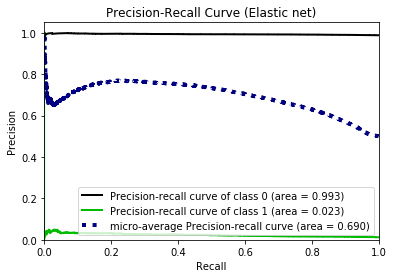

In [88]:
skplt.metrics.plot_precision_recall(y_test, log_probas, title='Precision-Recall Curve (Elastic net)')
plt.show()

As we increase the decision threshold, we can get arbitrarily high recall scores with very little hit to precision since it is always very low no matter what. The tradeoff is that we lose true negatives and gain false positives, which is not as much of a concern. We will explore this more later.

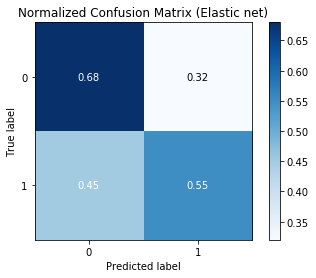

In [110]:
skplt.metrics.plot_confusion_matrix(y_test, log_y_hat, normalize=True, title='Normalized Confusion Matrix (Elastic net)')
plt.ylim(1.5,-0.5)
plt.show()

Our elastic net model predicted 55% of defaults correctly, while limiting the rate of incorrect current loans to 32%.

## Regression models

Model | MAE | R^2
--- | --- | ---
Linear regression | 6366 | 0.342
XGBoost | 6891 | 0.278
K-Neighbors | 6638 | 0.274

Linear regression performed the best in terms of both mean absolute error and R-squared.

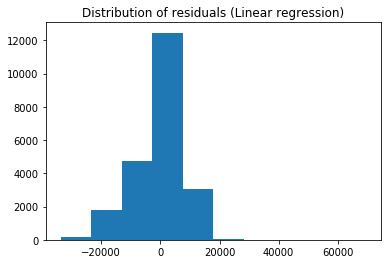

In [115]:
plt.hist(y_hat_lin-y_reg_test)
plt.title('Distribution of residuals (Linear regression)')
plt.show()

The residuals for this model are fairly normally distributed, a requirement in linear regression.

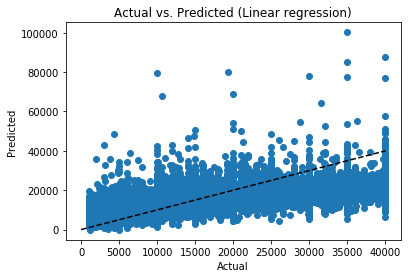

In [124]:
plt.scatter(y_reg_test,y_hat_lin)
x = np.linspace(0, 40000, 1000)
plt.plot(x,x, color='black', linestyle='dashed')
plt.title('Actual vs. Predicted (Linear regression)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Further analysis reveals that our model is overpredicting for low actual loan amounts and underpredicting for high actual loan amounts. Furthermore, our regression is predicting loan amounts above LendingClub's maximum. We could correct this in the future by mapping all predictions above the maximum to 40000.

# Modeling and Evaluation 5

As discussed earlier, elastic net logistic regression and linear regression performed the best on their respective tasks. For classification, random forest and XGBoost have the advantage of finishing relatively quickly, even accounting for testing best hyperparameters with cross-validation. Elastic net ran by far the slowest of the classification algorithms.

For regression, the linear regression model was fit nearly instantly, and the XGBoost also completed in a few seconds. K-Neighbors regression took 5 minutes to complete its randomized search of 300 trees, averaging about a second per tree.

# Modeling and Evaluation 6

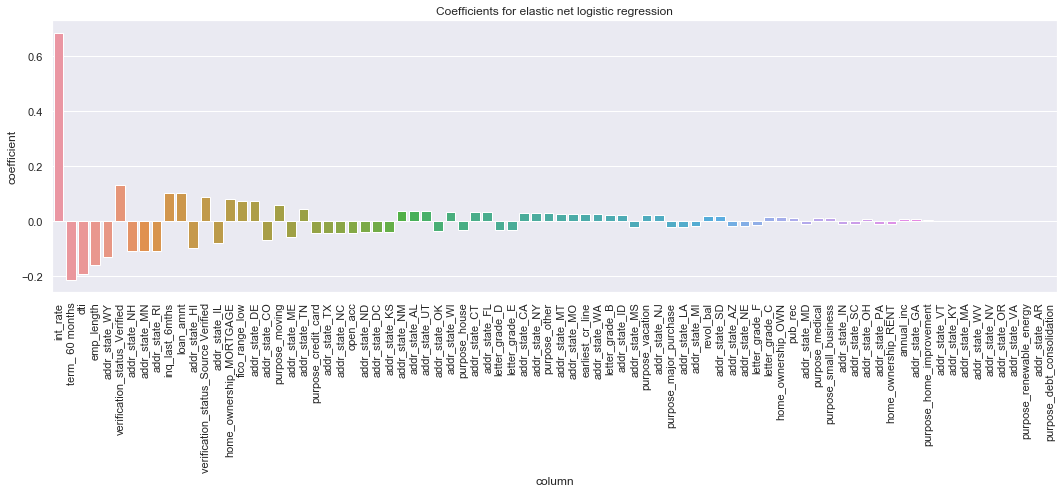

In [178]:
import seaborn as sns
log_coefs = pd.DataFrame({'column':X.columns, 'coefficient':log_model.coef_[0]})
log_coefs = log_coefs.reindex(log_coefs.coefficient.abs().sort_values(ascending=False).index)
sns.set()
fig, ax = plt.subplots(figsize=(18,5))
sns.barplot(x='column', y='coefficient', data=log_coefs)
plt.xticks(rotation=90)
plt.title('Coefficients for elastic net logistic regression')
plt.show()

For elastic net logistic regression, the top 5 features are int_rate, term_60 months, dti, emp_length, and addr_state_WY. Interest rate is overwhelmingly the most important factor determining whether our elastic net model predicts somebody to default on their loan. A higher rate leads to a higher probability of defaulting. Since higher rates cause loan payments to be greater, this makes sense intuitively. Our model also says that 60 month term loans (as opposed to 36) result in a lower chance of default. Longer terms would tend to have lower monthly payments, so this also makes sense. For greater debt-to-income ratios, there is a lower chance of default. This is counterintuitive, but perhaps customers who take on more debt are more responsible in general. Lower employment length is also associated with lower default rates. This is also counterintuitive, and for lack of a decent explanation could point to a problem with the model. Lastly, customers from Wyoming default at a lower rate than any other state, as we saw in our first project, to the point where being from Wyoming is a decent predictor of not defaulting.

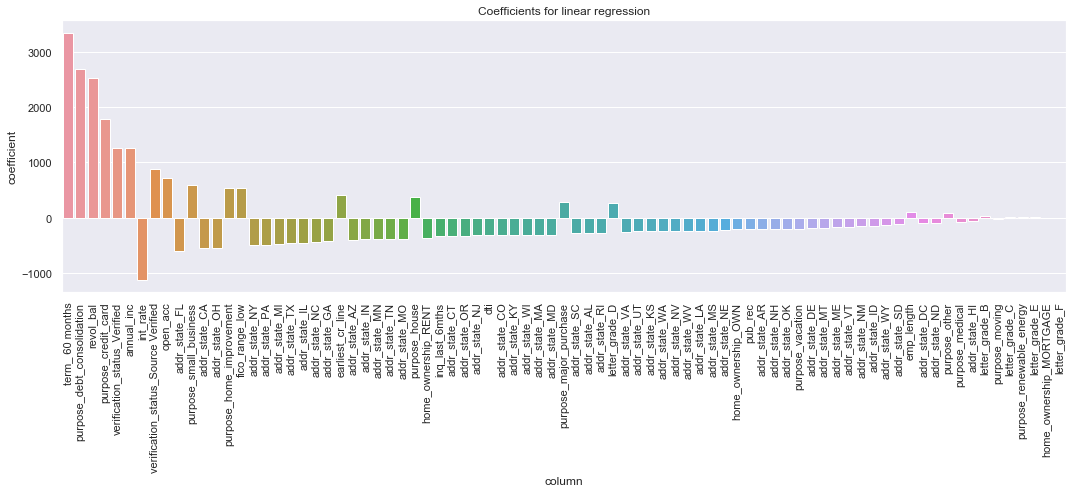

In [189]:
lin_coefs = pd.DataFrame({'column':X_reg.columns, 'coefficient':LReg.coef_})
lin_coefs = lin_coefs.reindex(lin_coefs.coefficient.abs().sort_values(ascending=False).index)
fig, ax = plt.subplots(figsize=(18,5))
sns.barplot(x='column', y='coefficient', data=lin_coefs)
plt.xticks(rotation=90)
plt.title('Coefficients for linear regression')
plt.show()

The top 5 factors for linear regression determing loan amount are term_60 months, purpose_debt_consolidation, revol_bal, purpose_credit_card, and verification_status_Verified. Loans of 60 months are probably given out more frequently for larger loan amounts, so this makes sense. Debt consolidation loans are taking several sources of debt and rolling them into one, so they are likely to be higher than average. Customers with higher revolving balance already have high levels of debt, so expecting them to take on even more makes sense. Credit card loans make sense for the same reasons as debt consolidation loans. Customers with verification status Verified are probably believed to be more trustworthy by LendingClub, allowing them to borrow more.

# Deployment

Our model is somewhat useful for predicting whether or not a loan will default, and fairly useful for predicting what we could offer a consumer and be repaid. As we've discussed already there are problems with this dataset- The number of defaulted loans are a very small percentage of this dataset, and don't have any substantially weighted features, so predicting defaults is hard. To measure the value of this model, we would score the loans that we evaluated as unlikely to default, invest in those, and see if our calculations held true. Ultimately the measure of this model's success would be our ROI for our invested dollars. To truly measure this efficacy we could invest in loans randomly with half of our money, and half of it in loans the model favors, and see which performs better.

As for predicting what LendingClub could offer consumers, this model would be a bit less useful. As consumers request an amount that lendingclub authorizes in the application process, it is hard to correlate the features here with the loan amount, as even millionaires sometimes want small loans, and low-income individuals want large loans. The natural variance in loan amount makes it hard to model.

To deploy this model, I would download all of the historical data available, train the model on the entirety of it, and build a small script to regularly pull the data and update the model, preferably nightly.
For other data, we do have all of the features typically on a credit application already, which is excellent! The biggest thing to expand if we were to bring this model to production is to use more historical data. Loan data is released on a constant basis, daily- We would need to implement this data so that we could make timely decisions on investments to make.

# Exceptional Work

## Arbitrary decision thresholds for elastic net logistic regression

In [191]:
for i in np.arange(0.35,.51,.01):
    y_hat_proba2 = np.where(log_probas[:,1] <= i, 0, 1)
    y_hat_proba2 = np.around(y_hat_proba2)
    print('For decision limit of', round(i,2))
    print('Recall:', mt.recall_score(y_test, y_hat_proba2))
    print('Precision:', mt.precision_score(y_test, y_hat_proba2))
    print('Balanced accuracy:', mt.balanced_accuracy_score(y_test,y_hat_proba2))
    print(mt.confusion_matrix(y_test, y_hat_proba2))

For decision limit of 0.35
Recall: 0.8218181818181818
Precision: 0.015463564830653437
Balanced accuracy: 0.5853366409136161
[[ 7709 14389]
 [   49   226]]
For decision limit of 0.36
Recall: 0.8036363636363636
Precision: 0.015693793495242154
Balanced accuracy: 0.5881925143369617
[[ 8237 13861]
 [   54   221]]
For decision limit of 0.37
Recall: 0.7854545454545454
Precision: 0.015975149767029066
Balanced accuracy: 0.5916819292572755
[[ 8793 13305]
 [   59   216]]
For decision limit of 0.38
Recall: 0.76
Precision: 0.016148972338123936
Balanced accuracy: 0.5918970042537786
[[ 9365 12733]
 [   66   209]]
For decision limit of 0.39
Recall: 0.7345454545454545
Precision: 0.016315321864146675
Balanced accuracy: 0.5917048025736594
[[ 9919 12179]
 [   73   202]]
For decision limit of 0.4
Recall: 0.7236363636363636
Precision: 0.01677343223196224
Balanced accuracy: 0.5978802688848847
[[10433 11665]
 [   76   199]]
For decision limit of 0.41
Recall: 0.7054545454545454
Precision: 0.017104567095750308


We can set arbitrary decision limits for the elastic net model to increase recall (more true negatives) at the expense of precision (more false positives). We tested decision limits between 0.35 and 0.50 and measured recall and precision. We also measured balanced accuracy (the average of recall for both positive and negative classes) to give us an idea of whether the tradeoff is worth it. We need a reasonable amount of true negatives (current loans predicted to be current) to have enough loans to invest in. If we use a decision threshold around 0.40 to 0.42, we can increase recall all the way to about 0.70 (an increase of 0.15, or about 28%) while still having about half of the current loans predicted correctly.

## TensorFlow regression

22373/22373 - 0s - loss: 78844817.1113 - mean_absolute_error: 6288.3975 - mean_squared_error: 78844832.0000


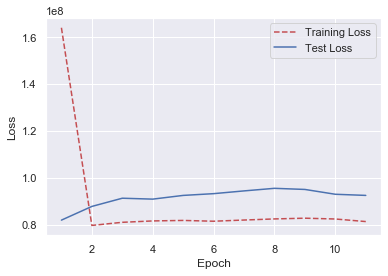

In [193]:
#tensorflow regression with two fully connected layers
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
tfReg = keras.Sequential([
   layers.Dense(81, activation = 'relu', input_shape = [81]),
   layers.Dense(64, activation='relu'),
   layers.Dense(1)
])
optimizer = tf.keras.optimizers.RMSprop(0.001)
tfReg.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = tfReg.fit(X_reg_train_scaled, y_reg_train, epochs=200,
                   validation_split = 0.2, verbose=0, callbacks=[early_stop])
loss, mae, mse = tfReg.evaluate(X_reg_test_scaled, y_reg_test, verbose=2)
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();